[]() FCC Pythia + Delphes + Heppy Analysis
==========================================================

-   [Overview](#overview)
-   [Generate and Simulate Events](#generate-events)
-   [Analyze Events](#analyze-events)
-   [Plot events](#plot-events)
-   [Homework exercise](#homework-exercise)


[]() Overview
---------------------

-   **generate** signal and background samples with **Pythia8** within FCCSW
-   run a fast parametric **detector simulation** with **Delphes** within FCCSW
-   apply an **event selection** on those samples with **Heppy**
-   produce **flat ntuples** with observables of interest with Heppy
-   produce plots

[]()Part I: Generate and simulate Events with FCCSW
----------------------------------------------------

For this tutorial we will consider the following **physics processes**:

-   p p -> H -> 4 l
-   p p -> Z/gamma Z/gamma -> 4 l

Pythia can be configured to hadronize previously generated hard scattering in the form of Les Houches event files (.lhe),
or generate the hard process itself and then run the parton shower and hadronization. **In either case, the FCCSW takes
as input a Pythia8 configuration file** (.cmd), and does not need to know which approach was used. 

For this tutorial, we are going to run Pythia8 on previously produced LHE files (with [MG5_aMCatNLO](https://launchpad.net/mg5amcnlo)). Additional Pythia8
configurations are present in ```Generation/data```. 

The following commands will run Pythia8 and Delphes and produce the relevant signal and background samples.

First clone the FCCSW repo to get the configuration files:

In [1]:
! git clone https://github.com/HEP-FCC/FCCSW.git

fatal: destination path 'FCCSW' already exists and is not an empty directory.


In [5]:
! FCCSWPATH=/cvmfs/fcc.cern.ch/sw/releases/0.9.1/x86_64-slc6-gcc62-opt/linux-scientificcernslc6-x86_64/gcc-6.2.0/fccsw-0.9.1-c5dqdyv4gt5smfxxwoluqj2pjrdqvjuj  && \
  cd FCCSW && \
  $FCCSWPATH/run $FCCSWPATH/scripts/fccrun.py Sim/SimDelphesInterface/options/PythiaDelphes_config.py --inputfile=Generation/data/Pythia_pp_h_4l.cmd --outputfile=pp_h_4l.root --nevents=100 && \
  $FCCSWPATH/run $FCCSWPATH/scripts/fccrun.py Sim/SimDelphesInterface/options/PythiaDelphes_config.py --inputfile=Generation/data/Pythia_pp_zgzg_4l.cmd --outputfile=pp_zgzg_4l.root --nevents=100

# setting LC_ALL to "C"
# --> Including file '/eos/user/j/jcervant/SWAN_projects/FCC-Gallery/FCCSW/Sim/SimDelphesInterface/options/PythiaDelphes_config.py'
# <-- End of file '/eos/user/j/jcervant/SWAN_projects/FCC-Gallery/FCCSW/Sim/SimDelphesInterface/options/PythiaDelphes_config.py'
ApplicationMgr    SUCCESS 
                                                   Welcome to FCCSW version HEAD
                                          running on 5e07b2dd2207 on Tue Apr  3 12:30:52 2018
ApplicationMgr       INFO Application Manager Configured successfully
** INFO: adding module        ParticlePropagator       ParticlePropagator       
** INFO: adding module        Efficiency               ChargedHadronTrackingEfficiency
** INFO: adding module        Efficiency               ElectronTrackingEfficiency
** INFO: adding module        Efficiency               MuonTrackingEfficiency   
** INFO: adding module        MomentumSmearing         ChargedHadronMomentumSmearing
** INFO: adding module     

ApplicationMgr       INFO Application Manager Started successfully
Pythia8.PileUpTool   INFO Current number of pileup events:  'numPileUpEvents':0

 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.230      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 6  Oct 2017  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |   P       Y      T    H   H  III  A   A    No

 |    pT0 =  4.04 gives sigmaInteraction =   780.27 mb: accepted    | 
 |                                                                  | 
 *-------  End PYTHIA Multiparton Interactions Initialization  -----* 
 PYTHIA Warning in MultipartonInteractions::init: maximum increased by factor 1.003

 *-------  PYTHIA Flag + Mode + Parm + Word + FVec + MVec + PVec + WVec Settings (changes only)  ------------------* 
 |                                                                                                                 | 
 | Name                                          |                      Now |      Default         Min         Max | 
 |                                               |                          |                                      | 
 | Beams:frameType                               |                        4 |            1           1           5 | 
 | Beams:LHEF                                    | /eos/project/f/fccsw-web/testsamples/pp_h_4l.lhe |         vo

             48     1   0.0000000    0       11        4 
             49     1   0.0000000    0       12        5 
             50     1   0.0000000    0       11        6 
             51     1   0.0000000    0       14        1 
             52     1   0.0000000    0       13        2 
             53     1   0.0000000    0       14        3 
             54     1   0.0000000    0       13        4 
             55     1   0.0000000    0       14        5 
             56     1   0.0000000    0       13        6 
             57     1   0.0000000    0       16        1 
             58     1   0.0000000    0       15        2 
             59     1   0.0000000    0       16        3 
             60     1   0.0000000    0       15        4 
             61     1   0.0000000    0       16        5 
             62     1   0.0000000    0       15        6 
             63     1   0.0000000    0       -2       -1 
             64     1   0.0000000    0       -2       -5 
             6


 --------  LHA event information and listing  ---------------------------------------------------------------------- 

    process =        2    weight =   2.6322e-02     scale =   1.2500e+02 (GeV) 
                        alpha_em =   7.5468e-03    alpha_strong =   1.2351e-01

    Participating Particles 
    no        id stat     mothers     colours      p_x        p_y        p_z         e          m        tau    spin 
     1        21   -1     0     0   502   501      0.000      0.000    166.600    166.600      0.000   0.000  -1.000
     2        21   -1     0     0   501   502     -0.000     -0.000    -23.446     23.446      0.000   0.000  -1.000
     3        25    2     1     2     0     0      0.000      0.000    143.154    190.046    124.997   0.000   0.000
     4        23    2     3     3     0     0      4.077    -15.742    128.367    158.069     90.793   0.000   0.000
     5       -13    1     3     3     0     0     -6.588      2.136     -4.486      8.252      0.000   0.

   286         21  (g)                -31   324     0   287   288   614   612  0.000e+00  0.000e+00 -1.193e+01  1.193e+01  0.000e+00
   287         21  (g)                -33   285   286   325   325   614   615 -7.257e-01  3.172e+00 -1.170e+01  1.214e+01  0.000e+00
   288         21  (g)                -33   285   286   326   326   615   613  7.257e-01 -3.172e+00  2.896e+02  2.896e+02  0.000e+00
   289         21  (g)                -41   383   383   295   207   616   534  4.441e-16 -1.735e-18  4.017e+03  4.017e+03  0.000e+00
   290         21  (g)                -42   384     0   208   208   537   584  2.220e-16  1.735e-18 -6.338e+01  6.338e+01  0.000e+00
   291         21  (g)                -44   209   209   385   385   537   534  1.161e+01  3.272e+00  6.957e+02  6.958e+02  0.000e+00
   292         21  (g)                -44   222   222   386   386   535   536 -5.081e+00 -9.537e-01  1.617e+03  1.617e+03  0.000e+00
   293         21  (g)                -44   220   220   387   387   5

  2362         21  (g)                -62  1056  1056  2548     0   671   642  1.508e-01 -8.280e-02  2.475e+00  2.481e+00  0.000e+00
  2363         21  (g)                -62  1244  1244  3480  3480   836   763  2.122e+00 -1.474e+00  2.575e+03  2.575e+03  0.000e+00
  2364         -3  (sbar)             -62  1622  1622  2804  2804     0   718  6.012e-01  1.003e+00  4.513e+02  4.513e+02  5.000e-01
  2365         21  (g)                -61     1     0   924   924   745   745  8.229e-01 -1.232e+00  9.175e+01  9.177e+01  0.000e+00
  2366         21  (g)                -61     2     0  1481  1481   670   670  1.238e+00 -2.458e+00 -5.989e+02  5.989e+02  0.000e+00
  2367         21  (g)                -62  1714  1714  3191  3191   592   722 -1.909e+00 -1.807e-02 -1.828e+00  2.643e+00  0.000e+00
  2368         21  (g)                -62   927   927  2891  2891   590  1010  1.623e+00 -2.175e+00  2.644e+01  2.658e+01  0.000e+00
  2369          3  (s)                -62  1496  1496  2486     0   5

  4491         22  gamma               91  3731     0     0     0     0     0 -7.384e-03  2.418e-01  3.088e+01  3.088e+01  0.000e+00
  4492         22  gamma               91  3733     0     0     0     0     0  3.346e-01  1.085e+00  2.464e+02  2.464e+02  0.000e+00
  4493         22  gamma               91  3733     0     0     0     0     0  1.584e-01  2.915e-01  6.546e+01  6.546e+01  0.000e+00
  4494        211  pi+                 91  3737     0     0     0     0     0 -9.654e-01  1.219e-01 -1.612e+01  1.615e+01  1.396e-01
  4495       -211  pi-                 91  3737     0     0     0     0     0 -1.267e-01 -9.634e-02 -2.689e+00  2.697e+00  1.396e-01
  4496         22  gamma               91  3739     0     0     0     0     0 -6.799e-03  2.230e-03 -1.082e-02  1.297e-02  0.000e+00
  4497         22  gamma               91  3739     0     0     0     0     0 -5.583e-01  2.011e-01 -6.028e+00  6.057e+00  0.000e+00
  4498         22  gamma               91  3743     0     0     0    

 PYTHIA Warning in Pythia::check: energy-momentum not quite conserved  

 Pythia::next(): 10 events have been generated 

 Pythia::next(): 20 events have been generated 

 Pythia::next(): 30 events have been generated 
 PYTHIA Warning in SpaceShower::pT2nextQCD: small daughter PDF  

 Pythia::next(): 40 events have been generated 

 Pythia::next(): 50 events have been generated 

 Pythia::next(): 60 events have been generated 

 Pythia::next(): 70 events have been generated 

 Pythia::next(): 80 events have been generated 
 PYTHIA Warning in StringFragmentation::fragmentToJunction: bad convergence junction rest frame  

 Pythia::next(): 90 events have been generated 
ApplicationMgr       INFO Application Manager Stopped successfully
DelphesSimulation    INFO Exiting Delphes...
Error in <TList::Clear>: A list is accessing an object (0x3af4210) already deleted (list name = TList)
EventLoopMgr         INFO Histograms converted successfully according to request.
ToolSvc              INFO R


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.230      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 6  Oct 2017  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |   P       Y      T    H   H  III  A   A    Now is 03 Apr 2018 at 12:31:59    |  | 
 |  |                                                                              |  | 
 |  |   Christian Bi

 |                                                                  | 
 |    pT0 =  4.04 gives sigmaInteraction =   780.27 mb: accepted    | 
 |                                                                  | 
 *-------  End PYTHIA Multiparton Interactions Initialization  -----* 
 PYTHIA Warning in MultipartonInteractions::init: maximum increased by factor 1.003

 *-------  PYTHIA Flag + Mode + Parm + Word + FVec + MVec + PVec + WVec Settings (changes only)  ------------------* 
 |                                                                                                                 | 
 | Name                                          |                      Now |      Default         Min         Max | 
 |                                               |                          |                                      | 
 | Beams:frameType                               |                        4 |            1           1           5 | 
 | Beams:LHEF                            

             93     1   0.0000000    0       -6       -1 
             94     1   0.0000000    0       -6       -5 

 2000004  ~u_5             ~u_5bar            1   2   1  500.00000    0.00000   50.00000    0.00000  0.00000e+00   1   0   0   1   0
              0     1   0.0000000  103  1000039        2 
              1     1   0.0000000  103  1000039        4 
              2     1   0.0000000  103  1000039        6 
              3     1   0.0000000    0  1000024        1 
              4     1   0.0000000    0  1000024        3 
              5     1   0.0000000    0  1000024        5 
              6     1   0.0000000    0  1000037        1 
              7     1   0.0000000    0  1000037        3 
              8     1   0.0000000    0  1000037        5 
              9     1   0.0000000    0  1000022        2 
             10     1   0.0000000    0  1000022        4 
             11     1   0.0000000    0  1000022        6 
             12     1   0.0000000    0  1000023       


 --------  LHA event information and listing  ---------------------------------------------------------------------- 

    process =        1    weight =   1.0377e+00     scale =   2.5702e+02 (GeV) 
                        alpha_em =   7.5468e-03    alpha_strong =   1.1090e-01

    Participating Particles 
    no        id stat     mothers     colours      p_x        p_y        p_z         e          m        tau    spin 
     1        -2   -1     0     0     0   501     -0.000      0.000     59.297     59.297      0.000   0.000   1.000
     2         2   -1     0     0   501     0      0.000     -0.000  -1240.981   1240.981      0.000   0.000  -1.000
     3        23    2     1     2     0     0   -209.481    117.680   -799.269    839.578     91.270   0.000   0.000
     4        23    2     1     2     0     0    209.481   -117.680   -382.415    460.699     90.948   0.000   0.000
     5       -11    1     4     4     0     0     20.887    -45.158   -116.875    127.025      0.000   0.

  1158         21  (g)                -51   845     0  1802  1802   575   812  2.539e-01 -3.152e-02  5.824e+00  5.830e+00  0.000e+00
  1159         21  (g)                -51   845     0  1822  1822   812   724 -8.403e-01 -2.470e+00  6.877e+01  6.882e+01  0.000e+00
  1160         21  (g)                -52   913   913  1813  1813   724   549  2.856e-01 -4.239e-01  7.073e+00  7.091e+00  0.000e+00
  1161         21  (g)                -51   769     0  1473  1473   813   706  2.728e-01  1.605e-01  2.294e-01  3.909e-01  0.000e+00
  1162         21  (g)                -51   769     0  1480  1480   509   813 -6.321e-01  5.589e-01 -9.897e-01  1.301e+00  0.000e+00
  1163          1  (d)                -53  1464  1464   760   760   509     0  1.125e-13 -2.220e-16 -9.743e+02  9.743e+02  0.000e+00
  1164         21  (g)                -51   922     0  1568  1568   814   572  3.387e-01  1.769e+00  3.298e+01  3.303e+01  0.000e+00
  1165         21  (g)                -51   922     0  1598  1598   5

  2662       -211  pi-                 84  2128  2148     0     0     0     0 -3.139e-02 -1.582e-01  1.019e+01  1.019e+01  1.396e-01
  2663        221  (eta)              -84  2128  2148  3270  3272     0     0  9.906e-01 -2.753e-01  2.269e+02  2.269e+02  5.478e-01
  2664        213  (rho+)             -84  2128  2148  2971  2972     0     0  6.749e-01 -2.548e-01  5.301e+02  5.301e+02  8.276e-01
  2665        221  (eta)              -84  2128  2148  3273  3275     0     0  5.979e-01 -8.480e-01  3.786e+02  3.786e+02  5.478e-01
  2666        311  (K0)               -84  2128  2148  2973  2973     0     0  6.055e-01  5.098e-01  6.715e+02  6.715e+02  4.976e-01
  2667       -323  (K*-)              -84  2128  2148  2974  2975     0     0  2.674e+00 -1.699e+00  1.960e+03  1.960e+03  8.845e-01
  2668        111  (pi0)              -84  2128  2148  3276  3278     0     0  3.298e-01  1.349e-02  6.048e+02  6.048e+02  1.350e-01
  2669        113  (rho0)             -84  2128  2148  2976  2977    

  3120         22  gamma               91  2310     0     0     0     0     0  1.091e+00  1.744e+00 -3.647e+00  4.187e+00  0.000e+00
  3121      -2112  nbar0               91  2311     0     0     0     0     0  2.734e+00  2.547e+00 -2.445e+00  4.563e+00  9.396e-01
  3122       -211  pi-                 91  2311     0     0     0     0     0  6.305e-01  7.660e-01 -8.758e-01  1.331e+00  1.396e-01
  3123        211  pi+                 91  2316     0     0     0     0     0  7.470e-03  4.685e-02  4.606e-02  1.544e-01  1.396e-01
  3124       -211  pi-                 91  2316     0     0     0     0     0  2.484e-01  1.128e+00  3.135e-01  1.205e+00  1.396e-01
  3125        111  (pi0)              -91  2316     0  3554  3555     0     0  2.321e-01  2.503e-01  1.886e-01  4.127e-01  1.350e-01
  3126        211  pi+                 91  2319     0     0     0     0     0 -6.828e-02  2.437e-01 -2.767e-02  2.903e-01  1.396e-01
  3127       -211  pi-                 91  2319     0     0     0    

  3686         22  gamma               91  3509     0     0     0     0     0 -3.760e-01  2.824e-01  2.210e+01  2.210e+01  0.000e+00
  3687         22  gamma               91  3514     0     0     0     0     0  1.281e-01 -2.147e-01  6.293e-02  2.578e-01  0.000e+00
  3688         22  gamma               91  3514     0     0     0     0     0  1.221e-01 -5.199e-01  2.516e-01  5.903e-01  0.000e+00
  3689         22  gamma               91  3515     0     0     0     0     0  1.524e-03  3.335e-02 -1.174e-02  3.539e-02  0.000e+00
  3690         22  gamma               91  3515     0     0     0     0     0  1.477e-01 -5.590e-02  8.942e-02  1.815e-01  0.000e+00
  3691         22  gamma               91  3520     0     0     0     0     0  6.567e-02 -2.597e-02  7.938e-01  7.969e-01  0.000e+00
  3692         22  gamma               91  3520     0     0     0     0     0  4.455e-02 -5.491e-02  1.450e-01  1.613e-01  0.000e+00
  3693         22  gamma               91  3523     0     0     0    

The `--inputfile` , `--outputfile` and `--nevents` options simply overwrite parameters that are defined in the main
configuration `Sim/SimDelphesInterface/options/PythiaDelphes_config.py`. For a complete discussion on the structure of configuration file, see [this page](https://github.com/HEP-FCC/FCCSW/blob/master/Sim/SimDelphesInterface/doc/FccPythiaDelphes.md).

Aside from I/O and number of events (which can be specified through command line),
for most use cases as a user you won't need to apply any change to the configuration file.

In addition to the **sequence of modules** to be executed, and which **output collections** to be stored in the output tree, the following
parameters can be specified via the configuration file:

-   `nEvents` --&gt; number
    of events to be simulated
-   `pythiaConfFile` --&gt;
    Pythia8 configuration file
-   `delphescard` --&gt;
    Delphes detector card
-   `out.filename` --&gt;
    name of output file

In this example, Delphes is run on the fly with the baseline FCC-hh detector configuration.
Other detector cards can be found in the ```$DELPHES_DIR/cards``` directory, such as a ATLAS, CMS or ILD detector configurations:
```delphes_card_ATLAS.tcl```, ```delphes_card_CMS.tcl``` and  ```delphes_card_ILD.tcl```. Many of the questions you might have on Delphes Fast Simulation are probably answered
[here](https://cp3.irmp.ucl.ac.be/projects/delphes/wiki/WorkBook).

You can see the created files:

In [8]:
! ls FCCSW/pp*

FCCSW/pp_h_4l.root  FCCSW/pp_zgzg_4l.root


Now overwrite the samples you just produced, with larger samples (10k events) that have been previously produced and stored in eos.

In [9]:
! export EOS_MGM_URL="root://eospublic.cern.ch"
! cp /eos/experiment/fcc/hh/tutorials/Higgs_4l/pp_h_4l.root .
! cp /eos/experiment/fcc/hh/tutorials/Higgs_4l/pp_zgzg_4l.root .

And again, check that your files are present in your current directory:

In [10]:
! ls .

analysis_ee_ZH_cfg.py	   FccSoftwareGettingStartedFastSim.ipynb
analysis_hh_ttbar_cfg.py   FCCSW
analysis_hh_ttbar_cfg.pyc  myoutput
ee_ZH_Zmumu_Hbb.root	   pp_h_4l.root
ee_ZH_Zmumu_Hbb.txt	   pp_zgzg_4l.root
FCCFullAnalysis.ipynb


The output is a ROOT file containing a tree in the FCC [Event Data Model structure](https://github.com/HEP-FCC/fcc-edm). It is browsable with ROOT:

```
root -l pp_h_4l.root
TBrowser t;
```

Plotting some basic quantities directly on this output is possible, although not very handy:

Welcome to JupyROOT 6.12/04


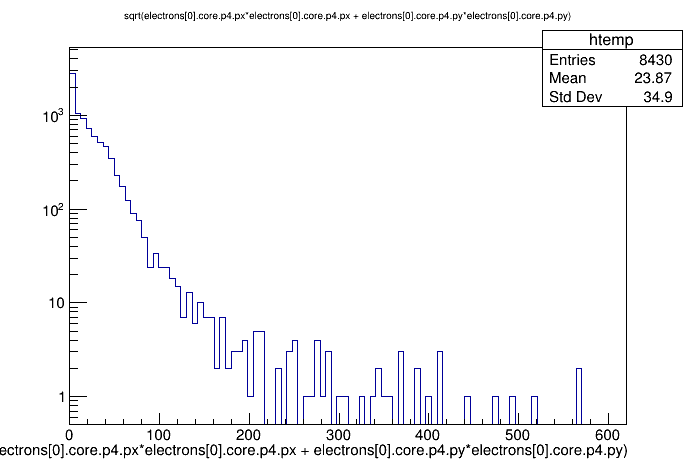

In [11]:
import ROOT

fname="pp_h_4l.root"

# Open file
f1 = ROOT.TFile(fname)

c1 = ROOT.TCanvas()
f1.events.Draw("sqrt(electrons[0].core.p4.px*electrons[0].core.p4.px + electrons[0].core.p4.py*electrons[0].core.p4.py)")
ROOT.gPad.SetLogy() 
c1.Draw()

[]()Part II: Analyze the output with Heppy
------------------------------------------


[Heppy](https://github.com/HEP-FCC/heppy) is a python framework suitable for analyzing the FCCSW output.

Understand the configuration file for this **H->4l analysis**: [`heppy/test/analysis_pp_hTo4l_simple_cfg.py`](https://github.com/HEP-FCC/heppy/blob/master/test/analysis_pp_hTo4l_simple_cfg.py)

This is where **filters** on input collections and **event selection** are defined.

The sequence is divided in two parts, a gen level analysis, and a reco level.

-   The **gen level analysis** simply filters interesting leptons (`gen_leptons`) and stores pT, eta in in flat tree (`gen_tree`).

Have a look at the corresponding code in [`heppy/analyzers/examples/hzz4l/HTo4lGenTreeProducer.py`](https://github.com/HEP-FCC/heppy/blob/master/analyzers/examples/hzz4l/HTo4lGenTreeProducer.py).

-   The **reco level analysis** first **selects isolated leptons** (`selected_muons`, `selected_electrons`), merges them into a single collection (`selected_leptons`),
**builds Z candidates** (`zeds`) and finally **builds higgs candidates**  (`higgses`). After that an **event selection** is applied (`selection`).

Open [`heppy/analyzers/examples/hzz4l/selection.py`](https://github.com/HEP-FCC/heppy/blob/master/analyzers/examples/hzz4l/selection.py) and understand the event selection.

Finally another flat tree is produced `HTo4lTreeProducer`.
This tree contains contains all relevant information for the two reconstructed Z bosons, the Higgs, and the four associated leptons.
For comparison, also the MC level counterparts of the reconstructed quantities are stored.

To summarize, when designing a new analysis, you will have to define:

- a configuration file containing the analysis sequence
- an event selection
- one or several tree producer(s) where the variables to be stored in the output tree(s) are specified
- optionally, new modules that are specific to your analysis (e.g. `LeptonicZedBuilder` here)

Let's now get the configuration file to run heppy:

In [19]:
! wget https://raw.githubusercontent.com/HEP-FCC/heppy/master/test/analysis_pp_hTo4l_simple_cfg.py

--2018-04-03 15:09:00--  https://raw.githubusercontent.com/HEP-FCC/heppy/master/test/analysis_pp_hTo4l_simple_cfg.py
Resolving raw.githubusercontent.com... 151.101.36.133
Connecting to raw.githubusercontent.com|151.101.36.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3960 (3.9K) [text/plain]
Saving to: “analysis_pp_hTo4l_simple_cfg.py”

100%[======================================>] 3,960       --.-K/s   in 0.001s  

2018-04-03 15:09:00 (2.77 MB/s) - “analysis_pp_hTo4l_simple_cfg.py” saved [3960/3960]



Now run HEPPY. 

In [20]:
! heppy_loop.py pp_h_4l analysis_pp_hTo4l_simple_cfg.py -N 10000 -I pp_h_4l.root;
! heppy_loop.py pp_zgzg_4l analysis_pp_hTo4l_simple_cfg.py -N 10000 -I pp_zgzg_4l.root;

TClass::Init:0: RuntimeWarning: no dictionary for class fcc::FloatData is available
event 100 (66.7 ev/s)
event 200 (87.7 ev/s)
event 300 (105.2 ev/s)
event 400 (117.8 ev/s)
event 500 (123.7 ev/s)
event 600 (127.3 ev/s)
event 700 (133.6 ev/s)
event 800 (138.8 ev/s)
event 900 (143.2 ev/s)
event 1000 (146.6 ev/s)
event 1100 (149.1 ev/s)
event 1200 (151.2 ev/s)
event 1300 (154.0 ev/s)
event 1400 (156.5 ev/s)
event 1500 (157.8 ev/s)
event 1600 (159.7 ev/s)
event 1700 (161.0 ev/s)
event 1800 (161.8 ev/s)
event 1900 (162.5 ev/s)
event 2000 (163.1 ev/s)
event 2100 (163.5 ev/s)
event 2200 (164.6 ev/s)
event 2300 (165.4 ev/s)
event 2400 (166.0 ev/s)
event 2500 (166.8 ev/s)
event 2600 (167.2 ev/s)
event 2700 (167.8 ev/s)
event 2800 (168.2 ev/s)
event 2900 (168.6 ev/s)
event 3000 (169.1 ev/s)
event 3100 (169.5 ev/s)
event 3200 (170.0 ev/s)
event 3300 (170.3 ev/s)
event 3400 (171.0 ev/s)
event 3500 (171.4 ev/s)
event 3600 (171.7 ev/s)
event 3700 (171.9 ev/s)
event 3800 (172.1 ev/s)
event 3900 (172

The runs create two output directories `pp_h_4l` and `pp_zgzg_4l`, with various subdirectories. The breakdown of
efficiencies by cut can be found in:

`pp_h_4l/example/heppy.analyzers.examples.hzz4l.selection.Selection_cuts/cut_flow.txt`

In [28]:
! less pp_h_4l/example/heppy.analyzers.examples.hzz4l.selection.Selection_cuts/cut_flow.txt | head

Counter cut_flow :
	 All events                                                       10000 	 1.00 	 1.0000
	 At least one Z -> l+ l- candidates                                9854 	 0.99 	 0.9854
	 40 < mZ1 < 120                                                    8271 	 0.84 	 0.8271
	 At least a second Z -> l+ l- candidates                           4646 	 0.56 	 0.4646
	 12 < mZ2 < 120                                                    4490 	 0.97 	 0.4490
	 leading lepton pT > 20                                            4454 	 0.99 	 0.4454
	 sub-leading lepton pT > 10                                        4450 	 1.00 	 0.4450



The **gen-level** and **reco-level** output trees can be found here:

In [31]:
! ls pp_h_4l/example/heppy.analyzers.examples.hzz4l.HTo4lGenTreeProducer.HTo4lGenTreeProducer_1/tree.root
! ls pp_h_4l/example/heppy.analyzers.examples.hzz4l.HTo4lTreeProducer.HTo4lTreeProducer_1/tree.root

! ls pp_zgzg_4l/example/heppy.analyzers.examples.hzz4l.HTo4lGenTreeProducer.HTo4lGenTreeProducer_1/tree.root
! ls pp_zgzg_4l/example/heppy.analyzers.examples.hzz4l.HTo4lTreeProducer.HTo4lTreeProducer_1/tree.root

pp_h_4l/example/heppy.analyzers.examples.hzz4l.HTo4lGenTreeProducer.HTo4lGenTreeProducer_1/tree.root
pp_h_4l/example/heppy.analyzers.examples.hzz4l.HTo4lTreeProducer.HTo4lTreeProducer_1/tree.root
pp_zgzg_4l/example/heppy.analyzers.examples.hzz4l.HTo4lGenTreeProducer.HTo4lGenTreeProducer_1/tree.root
pp_zgzg_4l/example/heppy.analyzers.examples.hzz4l.HTo4lTreeProducer.HTo4lTreeProducer_1/tree.root


[]()Part III: Produce plots
-----------------------

*Original code: [github.com/selvaggi/tutorials](https://github.com/selvaggi/tutorials)*

Produce Gen-level plots:

In [4]:
# Code to generate plots with some style 
! wget https://raw.githubusercontent.com/selvaggi/tutorials/master/fcc/tools/drawCanvas.py

--2018-04-03 15:40:03--  https://raw.githubusercontent.com/selvaggi/tutorials/master/fcc/tools/drawCanvas.py
Resolving raw.githubusercontent.com... 151.101.36.133
Connecting to raw.githubusercontent.com|151.101.36.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24757 (24K) [text/plain]
Saving to: “drawCanvas.py.1”

100%[======================================>] 24,757      --.-K/s   in 0.02s   

2018-04-03 15:40:03 (1.50 MB/s) - “drawCanvas.py.1” saved [24757/24757]



In [5]:
from ROOT import TFile, gROOT, TH1D, kRed, TLegend
from drawCanvas import *
import os

gROOT.SetBatch()

treeName = "events"
FileS = "pp_h_4l/example/heppy.analyzers.examples.hzz4l.HTo4lGenTreeProducer.HTo4lGenTreeProducer_1/tree.root"
FileB = "pp_zgzg_4l/example/heppy.analyzers.examples.hzz4l.HTo4lGenTreeProducer.HTo4lGenTreeProducer_1/tree.root"

Vars = {   
    "lep1vsPt_pt":{"name":"lep1vsPt_pt","title":"p_{T}^{(1)} [GeV]","bin":25,"xmin":0,"xmax":100},
    "lep2vsPt_pt":{"name":"lep2vsPt_pt","title":"p_{T}^{(2)} [GeV]","bin":25,"xmin":0,"xmax":100},
    "lep3vsPt_pt":{"name":"lep3vsPt_pt","title":"p_{T}^{(3)} [GeV]","bin":25,"xmin":0,"xmax":50},
    "lep4vsPt_pt":{"name":"lep4vsPt_pt","title":"p_{T}^{(4)} [GeV]","bin":25,"xmin":0,"xmax":50},

    "lep1vsEta_eta":{"name":"lep1vsEta_eta","title":"#eta^{(1)}","bin":25,"xmin":0,"xmax":10},
    "lep2vsEta_eta":{"name":"lep2vsEta_eta","title":"#eta^{(2)}","bin":25,"xmin":0,"xmax":10},
    "lep3vsEta_eta":{"name":"lep3vsEta_eta","title":"#eta^{(3)}","bin":25,"xmin":0,"xmax":10},
    "lep4vsEta_eta":{"name":"lep4vsEta_eta","title":"#eta^{(4)}","bin":25,"xmin":0,"xmax":10}
}


dict_histoS = {var:TH1D(var+"S",var+"S;"+Vars[var]["title"]+";",Vars[var]["bin"],Vars[var]["xmin"],Vars[var]["xmax"]) for var in Vars}
dict_histoB = {var:TH1D(var+"B",var+"B;"+Vars[var]["title"]+";",Vars[var]["bin"],Vars[var]["xmin"],Vars[var]["xmax"]) for var in Vars}

rootFileS = TFile(FileS,"read")
treeS = rootFileS.Get(treeName)
rootFileB = TFile(FileB,"read")
treeB = rootFileB.Get(treeName)

for entry in xrange(treeS.GetEntries()) :
    treeS.GetEntry(entry)
    for var in Vars.keys() :
        dict_histoS[var].Fill(getattr(treeS,Vars[var]["name"]))

for entry in xrange(treeB.GetEntries()) :
    treeB.GetEntry(entry)
    for var in Vars.keys() :
        dict_histoB[var].Fill(getattr(treeB,Vars[var]["name"]))

myBTGStyle()

yAxisLabel = "a. u."

rightText = "GEN"
leftText = "#sqrt{s} = 100 TeV"
format = "png"
outputDirectory = "plots" 

if not os.path.exists(outputDirectory) :
    os.system("mkdir "+outputDirectory)

for var in Vars.keys() : 
    dict_histoS[var].SetLineWidth(3)
    dict_histoS[var].SetLineWidth(3)
    dict_histoB[var].SetLineColor(ROOT.kRed)
   
    try : 
        dict_histoS[var].Scale(1./float(dict_histoS[var].Integral()))
        dict_histoB[var].Scale(1./float(dict_histoB[var].Integral()))
    except ZeroDivisionError :
        print "Can not renormalize because of integral = 0." 
    
    leg = TLegend(0.50,0.76,0.89,0.89)
    leg.AddEntry(dict_histoS[var],"p p #rightarrow H #rightarrow 4l","l")
    leg.AddEntry(dict_histoB[var],"p p #rightarrow ZZ / Z #gamma^{*} #rightarrow 4l","l")
    leg.SetFillColor(0)
    leg.SetFillStyle(0)
    leg.SetLineColor(0)

    drawDoublehisto(dict_histoS[var],dict_histoB[var],var,yAxisLabel,leg,leftText,rightText,format,outputDirectory,0)


AttributeError: 'PyROOT_NoneType' object has no attribute 'Fill'

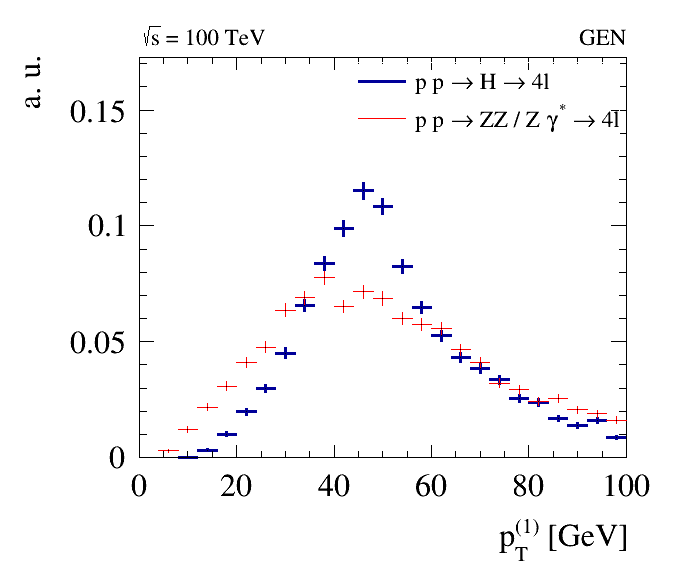

In [8]:
from IPython.display import Image
Image(filename='plots/lep1vsPt_pt.png') 

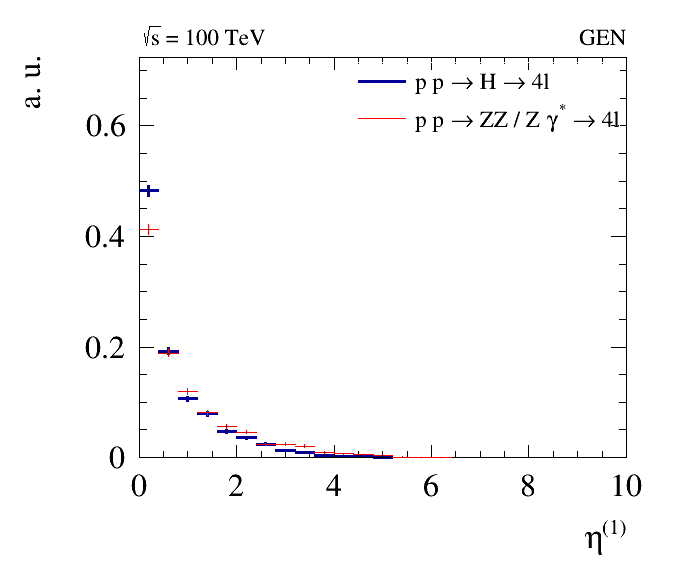

In [12]:
Image(filename='plots/lep1vsEta_eta.png') 

The rest of produced images are stored in your cernbox:



In [13]:
! ls plots/

lep1vsEta_eta.png  lep2vsEta_eta.png  lep3vsEta_eta.png  lep4vsEta_eta.png
lep1vsPt_pt.png    lep2vsPt_pt.png    lep3vsPt_pt.png	 lep4vsPt_pt.png


Produce Reco-level plots:

*Original code: [github.com/selvaggi/tutorials](https://github.com/selvaggi/tutorials)*

In [15]:
from ROOT import TFile, gROOT, TH1D, kRed, TLegend, THStack
from drawCanvas import *
import os

gROOT.SetBatch()

treeName = "events"
FileS = "pp_h_4l/example/heppy.analyzers.examples.hzz4l.HTo4lTreeProducer.HTo4lTreeProducer_1/tree.root"
FileB = "pp_zgzg_4l/example/heppy.analyzers.examples.hzz4l.HTo4lTreeProducer.HTo4lTreeProducer_1/tree.root"

# number of generated events
nGenS = 10000
nGenB = 10000

# integrated luminosity
intLumi = 25000

kFactorS = 3.50
kFactorB = 1.80

# MG5 LO XS x BR in (pb)
sigmaS = 0.026
sigmaB = 1.04

weightS = kFactorS*sigmaS*intLumi/nGenS
weightB = kFactorB*sigmaB*intLumi/nGenB

Vars = {   
    "zed1_m":{"name":"zed1_m","title":"m_{ll}^{(1)} [GeV]","bin":36,"xmin":0,"xmax":100},
    "zed2_m":{"name":"zed2_m","title":"m_{ll}^{(2)} [GeV]","bin":36,"xmin":0,"xmax":100},
    "higgs_m":{"name":"higgs_m","title":"m_{4l} [GeV]","bin":36,"xmin":70,"xmax":170},
}


dict_histoS = {var:TH1D(var+"S",var+"S;"+Vars[var]["title"]+";",Vars[var]["bin"],Vars[var]["xmin"],Vars[var]["xmax"]) for var in Vars}
dict_histoB = {var:TH1D(var+"B",var+"B;"+Vars[var]["title"]+";",Vars[var]["bin"],Vars[var]["xmin"],Vars[var]["xmax"]) for var in Vars}

rootFileS = TFile(FileS,"read")
treeS = rootFileS.Get(treeName)
rootFileB = TFile(FileB,"read")
treeB = rootFileB.Get(treeName)


for entry in xrange(treeS.GetEntries()) :
    treeS.GetEntry(entry)

    for var in Vars.keys() :
        dict_histoS[var].Fill(getattr(treeS,Vars[var]["name"]))

for entry in xrange(treeB.GetEntries()) :
    treeB.GetEntry(entry)
    for var in Vars.keys() :
        dict_histoB[var].Fill(getattr(treeB,Vars[var]["name"]))

myBTGStyle()

yAxisLabel = "Events / 2.5 GeV"

rightText = "RECO: Delphes-3.4.0"
leftText = "#sqrt{s} = 100 TeV, L = 25 fb^{-1}"
format = "png"
outputDirectory = "plots" 
outFile = outputDirectory+"/plots.root"

if not os.path.exists(outputDirectory) :
    os.system("mkdir "+outputDirectory)

for var in Vars.keys() : 
     
    try : 
        
	# rescale by
        dict_histoS[var].Scale(weightS)
        dict_histoB[var].Scale(weightB)

    except ZeroDivisionError :
        print "Can not renormalize because of integral = 0." 
    
    leg = TLegend(0.69,0.75,0.88,0.88)
    leg.AddEntry(dict_histoB[var],"ZZ / Z #gamma^{*}","f")
    leg.AddEntry(dict_histoS[var],"H(125)","l")
    leg.SetFillColor(0)
    leg.SetFillStyle(0)
    leg.SetLineColor(0)

    hS = dict_histoS[var]
    hB = []
    hB.append(dict_histoB[var])

    drawStack(var,yAxisLabel,leg,leftText,rightText,format,outputDirectory,0,hS,hB)


Info in <TCanvas::Print>: png file plots/higgs_m.png has been created
Info in <TCanvas::Print>: png file plots/zed2_m.png has been created
Info in <TCanvas::Print>: png file plots/zed1_m.png has been created


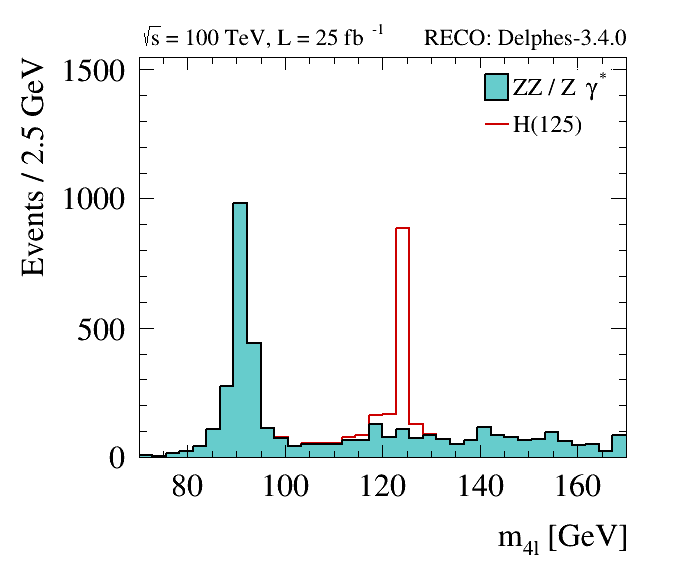

In [17]:
Image(filename='plots/higgs_m.png') 

Appreciate the signal yield for **25 fb-1 of data**. Compare with [ATLAS results](https://arxiv.org/pdf/1408.5191v3.pdf) at 7,8 TeV .

<img src="http://fccsw.web.cern.ch/fccsw/tutorials/fcc-tutorials/images/FccFullAnalysis/m4l_80_170_allYear_125.png" width="620" align="left">

[]()Part IV: Homework
---------------------

As an exercise you can **re-run the full analysis with the CMS detector configuration** .Additional Delphes card can
be found in ```$FCCVIEW/cards```). 

Hint: The input Delphes card can be specified in the command line argument: 

```
--delphescard=$DELPHES_DIR/cards/delphes_card_CMS.tcl
```

You should obtain a plot similar to the following:

<img src="http://fccsw.web.cern.ch/fccsw/tutorials/fcc-tutorials/images/FccFullAnalysis/higgs_m_cms.png" width="600">

By comparing the CMS and FCC Delphes cards, try to explain:

-  the **event yields difference between 7/8 TeV and 100 TeV** (by comparing the official ATLAS plot with the CMS configuration you just ran at 100 TeV)
-  the **event yields difference at 100 TeV** between the CMS and FCC detector configurations
-  the **difference in the width of Z and H peaks** between the CMS and FCC detector configurations


[]() Other documentation
------------------------

-   [Submit FCCSW jobs using the condor queue](https://github.com/HEP-FCC/fcc-tutorials/blob/master/FccCondor.md)
-   [Submit Heppy jobs using the batch queue](https://github.com/HEP-FCC/heppy/blob/master/doc/Heppy_-_Parallel_Processing.md)
-   [FCCSW webpage](http://fccsw.web.cern.ch/fccsw/index.html)
-   [Pythia8 manual](http://home.thep.lu.se/~torbjorn/pythia81html/Welcome.html)
-   [Delphes website](https://cp3.irmp.ucl.ac.be/projects/delphes)

------------------------------------------------------------------------